<a href="https://colab.research.google.com/github/kunal077/Financial-Engineering/blob/main/ReinforcementLearninginStockTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
!pip install yfinance --upgrade --no-cache-dir
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
from collections import deque
import random
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

Requirement already up-to-date: yfinance in /usr/local/lib/python3.7/dist-packages (0.1.59)


In [14]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("INFY", start="2018-01-01").reset_index()
df_full.to_csv('INFY.csv',index=False)
df_full.head()

[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,8.135,8.195,8.115,8.145,7.429263,12298200
1,2018-01-03,8.120,8.135,8.050,8.075,7.365414,10250800
2,2018-01-04,8.100,8.100,8.010,8.025,7.319807,16272000
3,2018-01-05,8.085,8.190,8.075,8.175,7.456626,9813600
4,2018-01-08,8.190,8.260,8.170,8.240,7.515914,11198200


In [15]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [16]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size = window_size, window_size = window_size, trend = close, 
              skip = skip, batch_size = batch_size)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


epoch: 10, total rewards: 5.840002.3, cost: 0.009371, total money: 10005.840002
epoch: 20, total rewards: 3.564999.3, cost: 0.007659, total money: 10003.564999
epoch: 30, total rewards: 4.579999.3, cost: 0.007132, total money: 10004.579999
epoch: 40, total rewards: 3.699999.3, cost: 0.006885, total money: 10003.699999
epoch: 50, total rewards: 5.685000.3, cost: 0.007829, total money: 10005.685000
epoch: 60, total rewards: 5.785000.3, cost: 0.008844, total money: 10005.785000
epoch: 70, total rewards: 6.679999.3, cost: 0.008975, total money: 10006.679999
epoch: 80, total rewards: 3.215000.3, cost: 0.007134, total money: 10003.215000
epoch: 90, total rewards: 2.205000.3, cost: 0.006900, total money: 10002.205000
epoch: 100, total rewards: 3.764999.3, cost: 0.006662, total money: 10003.764999
epoch: 110, total rewards: 5.249999.3, cost: 0.006459, total money: 10005.249999
epoch: 120, total rewards: 7.304999.3, cost: 0.006276, total money: 10007.304999
epoch: 130, total rewards: 5.679999.3

In [17]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 8.145000, total balance 9991.855000
day 1: buy 1 unit at price 8.075000, total balance 9983.780000
day 2: buy 1 unit at price 8.025000, total balance 9975.755000
day 4: buy 1 unit at price 8.240000, total balance 9967.515000
day 5, sell 1 unit at price 8.370000, investment 2.762431 %, total balance 9975.885000,
day 6, sell 1 unit at price 8.495000, investment 5.201238 %, total balance 9984.380000,
day 7, sell 1 unit at price 8.635000, investment 7.601246 %, total balance 9993.015000,
day 8, sell 1 unit at price 8.405000, investment 2.002427 %, total balance 10001.420000,
day 12: buy 1 unit at price 8.995000, total balance 9992.425000
day 15: buy 1 unit at price 9.230000, total balance 9983.195000
day 16: buy 1 unit at price 9.225000, total balance 9973.970000
day 20: buy 1 unit at price 9.005000, total balance 9964.965000
day 22: buy 1 unit at price 8.875000, total balance 9956.090000
day 23, sell 1 unit at price 8.685000, investment -3.446359 %, total balanc

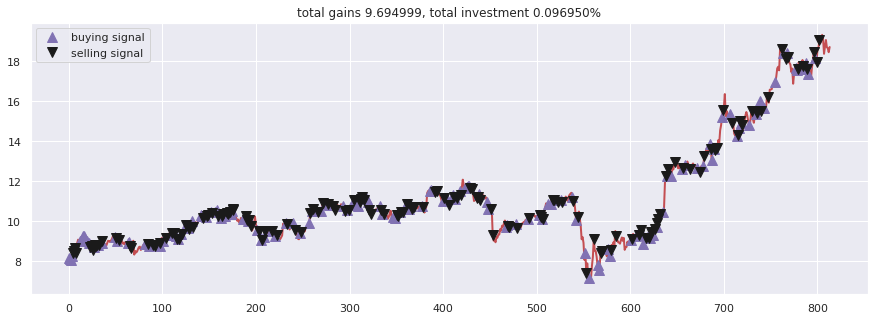

In [18]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()